
**Data Science Challenge: Card Transactions!**


### Brief summary

A highly imbalanced dataset of normal and fraudulent credit card transactions in analyzed. The fraudulent transactions represent about $1.5\%$ of the total.

The key findings of these study are (related to the questions):

- Transactions follow a long-tailed distribution, with most transactions being of small amounts ($<10 \$$).

- Reversed transactions have a proportinally higher chance to be fraudulent, especially as we increase the transaction amount, reaching about $6 \%$ for amounts $>500 \$$.

- A classification model is build to predict whether a transaction is fraudulent or not. Although some models were able to achieve high recall (about $0.82$) on an (imbalanced) test set, the precision was extremely low. In other words, although the model was *indeed* able to find most of the fraudulent transactions, it was also flagging many normal transactions as fraudulent.

- The most important features in the model are found to be the average past fraud, the fraction of  a transaction amount over the average of past transactions and the transaction amount itself.




In the following cell we import all the python packages we are going to need for our analysis. 
It is better to have them organized in the first cell.

In [1]:
# Import basic libraries
import numpy as np
import scipy as sp
import pandas as pd

from datetime import datetime

# =====================================
# scikit-learn and imbalanced-learn

# Preprocessing etc
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Evaluation metrics
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import balanced_accuracy_score as bas
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics.pairwise import euclidean_distances


# Imbalance-learn
import imblearn
from imblearn.under_sampling import RandomUnderSampler 
from imblearn.over_sampling import SMOTE 
from imblearn.pipeline import Pipeline 

# =====================================
# Matplotlib, seaborn etc 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'

# Adjust rc parameters to make plots pretty
def plot_pretty(dpi=200, fontsize=9):
    

    plt.rc("savefig", dpi=dpi)       # dpi resolution of saved image files
    plt.rc('text', usetex=True)      # use LaTeX to process labels
    plt.rc('font', size=fontsize)    # fontsize
    plt.rc('xtick', direction='in')  # make axes ticks point inward
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=10) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=10) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [0.5, 1.1]) # fix dotted lines

    return

plot_pretty()

# Define Capital One colors 
cap1_blue ='#004879'
cap1_red = '#D22E1E'
# ======================================

**Requirements**

If you want to run the code, you will need python 3 and the following packages:

In [35]:
print('numpy version:',np.__version__)
print('scipy version:',sp.__version__)
print('pandas version:',pd.__version__)
print('scikit-learn version:',sklearn.__version__)
print('imbalanced-learn version:',imblearn.__version__)
print('matplotlib version:',matplotlib.__version__)
print('seaborn version:',sns.__version__)

numpy version: 1.19.5
scipy version: 1.8.0
pandas version: 1.2.0
scikit-learn version: 1.0.1
imbalanced-learn version: 0.9.0
matplotlib version: 3.3.3
seaborn version: 0.11.1


# Question 1: Load 
**Load and simple preprocessing**

In the first part we load the data and perform some basic data preprocessing.

## Load the dataset

In [3]:
# Load the file, which is line-delimited JSON format 
# Convert it into a pandas dataframe
trans_df = pd.read_json('transactions.txt', lines=True)
# Some of the missing values are in form of "" delimeters, replace with nan
trans_df.replace('', np.nan, inplace=True)

# Let us check the first few values
trans_df.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,...,NaN,0.0,NaN,NaN,NaN,False,NaN,NaN,False,False
1,737265056,737265056,5000,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,...,NaN,0.0,NaN,NaN,NaN,True,NaN,NaN,False,False
2,737265056,737265056,5000,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,...,NaN,0.0,NaN,NaN,NaN,False,NaN,NaN,False,False
3,737265056,737265056,5000,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,...,NaN,0.0,NaN,NaN,NaN,False,NaN,NaN,False,False
4,830329091,830329091,5000,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,...,NaN,0.0,NaN,NaN,NaN,True,NaN,NaN,False,False


**Let's get a sense of the names of the columns**

In [4]:
trans_df.columns

Index(['accountNumber', 'customerId', 'creditLimit', 'availableMoney',
       'transactionDateTime', 'transactionAmount', 'merchantName',
       'acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode',
       'merchantCategoryCode', 'currentExpDate', 'accountOpenDate',
       'dateOfLastAddressChange', 'cardCVV', 'enteredCVV', 'cardLast4Digits',
       'transactionType', 'echoBuffer', 'currentBalance', 'merchantCity',
       'merchantState', 'merchantZip', 'cardPresent', 'posOnPremises',
       'recurringAuthInd', 'expirationDateKeyInMatch', 'isFraud'],
      dtype='object')

**Get some general information about non-null count and data type**

In [4]:
trans_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786363 entries, 0 to 786362
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   accountNumber             786363 non-null  int64  
 1   customerId                786363 non-null  int64  
 2   creditLimit               786363 non-null  int64  
 3   availableMoney            786363 non-null  float64
 4   transactionDateTime       786363 non-null  object 
 5   transactionAmount         786363 non-null  float64
 6   merchantName              786363 non-null  object 
 7   acqCountry                781801 non-null  object 
 8   merchantCountryCode       785639 non-null  object 
 9   posEntryMode              782309 non-null  object 
 10  posConditionCode          785954 non-null  object 
 11  merchantCategoryCode      786363 non-null  object 
 12  currentExpDate            786363 non-null  object 
 13  accountOpenDate           786363 non-null  o

**Drop columns that have only null values**

In [23]:
 trans_df.drop(['echoBuffer','merchantCity','merchantState','merchantZip','posOnPremises','recurringAuthInd'], axis=1, inplace=True)

## Description of the structure of the data

The dataset consists of 786363 entries (number of records) and a total number of 28 fields for each record. We found above that 6 fields are totally empty, so we drop them.
Finally, we have 786363 entries and 22 non-null fields.

## Description and summary statistics for the fields in the dataset

We can apply the `describe()` pandas method to our dataset.

In [6]:
trans_df.describe()

,accountNumber,customerId,creditLimit,availableMoney,transactionAmount,cardCVV,enteredCVV,cardLast4Digits,currentBalance
count,7.863630e+05,7.863630e+05,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000
mean,5.372326e+08,5.372326e+08,10759.464459,6250.725369,136.985791,544.467338,544.183857,4757.417799,4508.739089
std,2.554211e+08,2.554211e+08,11636.174890,8880.783989,147.725569,261.524220,261.551254,2996.583810,6457.442068
min,1.000881e+08,1.000881e+08,250.000000,-1005.630000,0.000000,100.000000,0.000000,0.000000,0.000000
25%,3.301333e+08,3.301333e+08,5000.000000,1077.420000,33.650000,310.000000,310.000000,2178.000000,689.910000
50%,5.074561e+08,5.074561e+08,7500.000000,3184.860000,87.900000,535.000000,535.000000,4733.000000,2451.760000
75%,7.676200e+08,7.676200e+08,15000.000000,7500.000000,191.480000,785.000000,785.000000,7338.000000,5291.095000
max,9.993896e+08,9.993896e+08,50000.000000,50000.000000,2011.540000,998.000000,998.000000,9998.000000,47498.810000


So, let us try to describe each one of the fields in the dataset with the appropriate metrics.

Let us check one-by-one some of the most important columns/fields.
**If you want a quick reference of the statistics of the dataset, you can skip the detailed analysis below and check directly the "quick summary statistics for reference" section.**

- `accountNumber`: This field contains the account numbers for each transaction.  Let us check for NaN values and number of entries (unique accounts).

In [7]:
print('Null values, accountNumber:',trans_df['accountNumber'].isna().sum())

Null values, accountNumber: 0


Great, we have zero null values. Let us check for unique values.

In [8]:
print('Unique values, accountNumber:',trans_df['accountNumber'].nunique())

Unique values, accountNumber: 5000


We have 5000 different account numbers in our dataset. I am curious if some of them dominate the transaction numbers in the dataset. For that reason, let's plot the frequency (make a histogram) of unique account numbers. 

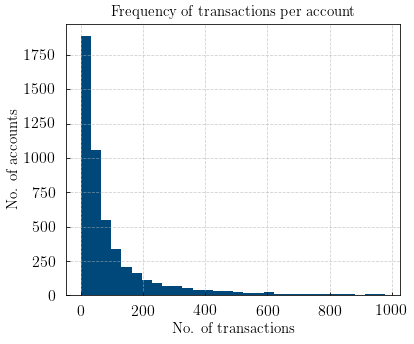

In [6]:
Unique_acNumbers = trans_df['accountNumber'].value_counts(normalize=False).values

# Make a plot 
plt.figure(figsize=(6,5))

plt.hist(Unique_acNumbers[Unique_acNumbers<1000],color=cap1_blue, bins=30)
plt.grid(ls='--',alpha=0.6)
plt.title('Frequency of transactions per account',fontsize=15)
plt.xticks(fontsize=16);plt.yticks(fontsize=16)
plt.xlabel('No. of transactions', fontsize=15);plt.ylabel('No. of accounts', fontsize=15)
plt.show()

We see that the the majority of accounts have a small number of transactions ($<100$), with a small number of accounts having many transactions ($>1000$). It is something that is good to have in mind in future investigations.

- `customerId`

This field seems to be the same as acount number. Let's confirm that.

In [7]:
print((trans_df['accountNumber'] - trans_df['customerId']).sum())

0


- `transactionDateTime`

Let's convert this column to datetime, for future ease

In [8]:
trans_df['transactionDateTime'] = pd.to_datetime(trans_df['transactionDateTime'],infer_datetime_format=True)

In [31]:
print("Datetime start:",trans_df['transactionDateTime'].dt.date.min())
print("Datetime ends:",trans_df['transactionDateTime'].dt.date.max())

Datetime start: 2016-01-01
Datetime ends: 2016-12-30


- `transactionAmount`

We can see from the info that it doesn't have null values

In [14]:
print('Minimun amount:',trans_df['transactionAmount'].values.min())
print('Maximum amount:',trans_df['transactionAmount'].values.max())

Minimun amount: 0.0
Maximum amount: 2011.54


In [24]:
trans_df[0:5]

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000,5000.0,2016-08-13 14:27:32,98.55,Uber,US,US,02,...,2015-03-14,2015-03-14,414,414,1803,PURCHASE,0.0,False,False,False
1,737265056,737265056,5000,5000.0,2016-10-11 05:05:54,74.51,AMC #191138,US,US,09,...,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,True,False,False
2,737265056,737265056,5000,5000.0,2016-11-08 09:18:39,7.47,Play Store,US,US,09,...,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,False,False,False
3,737265056,737265056,5000,5000.0,2016-12-10 02:14:50,7.47,Play Store,US,US,09,...,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,False,False,False
4,830329091,830329091,5000,5000.0,2016-03-24 21:04:46,71.18,Tim Hortons #947751,US,US,02,...,2015-08-06,2015-08-06,885,885,3143,PURCHASE,0.0,True,False,False


In [22]:
print('Min credit limit:',trans_df['creditLimit'].values.min())
print('Max credit limit:',trans_df['creditLimit'].values.max())

Min credit limit: 250
Max credit limit: 50000


For the rest of the columns check the statistics below.

**Number of unique values, null values, min and max values at each column**

Note that the min and max values are not very meaningful for some columns

- Null values

In [27]:
trans_df.isna().sum()

accountNumber                  0
customerId                     0
creditLimit                    0
availableMoney                 0
transactionDateTime            0
transactionAmount              0
merchantName                   0
acqCountry                  4562
merchantCountryCode          724
posEntryMode                4054
posConditionCode             409
merchantCategoryCode           0
currentExpDate                 0
accountOpenDate                0
dateOfLastAddressChange        0
cardCVV                        0
enteredCVV                     0
cardLast4Digits                0
transactionType              698
currentBalance                 0
cardPresent                    0
expirationDateKeyInMatch       0
isFraud                        0
dtype: int64

- Unique values

In [28]:
trans_df.nunique()

accountNumber                 5000
customerId                    5000
creditLimit                     10
availableMoney              521915
transactionDateTime         776637
transactionAmount            66038
merchantName                  2490
acqCountry                       4
merchantCountryCode              4
posEntryMode                     5
posConditionCode                 3
merchantCategoryCode            19
currentExpDate                 165
accountOpenDate               1820
dateOfLastAddressChange       2184
cardCVV                        899
enteredCVV                     976
cardLast4Digits               5245
transactionType                  3
currentBalance              487318
cardPresent                      2
expirationDateKeyInMatch         2
isFraud                          2
dtype: int64

- **Minimum values**

(Note: not always miningful)

In [20]:
print(trans_df.min())

accountNumber                         100088067
customerId                            100088067
creditLimit                                 250
availableMoney                         -1005.63
transactionDateTime         2016-01-01 00:01:02
transactionAmount                          0.00
merchantName                            1st BBQ
merchantCategoryCode                    airline
currentExpDate                          01/2020
accountOpenDate                      1989-08-22
dateOfLastAddressChange              1989-08-22
cardCVV                                     100
enteredCVV                                    0
cardLast4Digits                               0
echoBuffer                                  NaN
currentBalance                             0.00
merchantCity                                NaN
merchantState                               NaN
merchantZip                                 NaN
cardPresent                               False
posOnPremises                           

- **Maximum values**

In [21]:
print(trans_df.max())

accountNumber                         999389635
customerId                            999389635
creditLimit                               50000
availableMoney                         50000.00
transactionDateTime         2016-12-30 23:59:45
transactionAmount                       2011.54
merchantName                 williamssonoma.com
merchantCategoryCode              subscriptions
currentExpDate                          12/2032
accountOpenDate                      2015-12-31
dateOfLastAddressChange              2016-12-30
cardCVV                                     998
enteredCVV                                  998
cardLast4Digits                            9998
echoBuffer                                  NaN
currentBalance                         47498.81
merchantCity                                NaN
merchantState                               NaN
merchantZip                                 NaN
cardPresent                                True
posOnPremises                           

# Question 2: Plot 

In this part we plot a histogram of the processed amounts of each transaction.

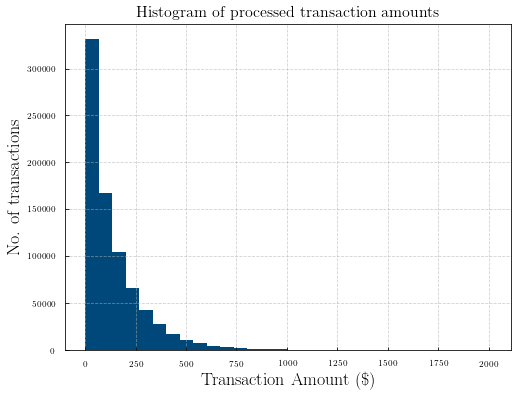

In [42]:
prossAmount = trans_df['transactionAmount'].values


plt.figure(figsize=(8,6))
plt.hist(prossAmount, color=cap1_blue, bins=30)
plt.grid(ls='--',alpha=0.6)
plt.title("Histogram of processed transaction amounts", fontsize=16)
plt.xlabel(r'Transaction Amount $(\$)$',fontsize=18);plt.ylabel('No. of transactions', fontsize=18)
plt.show()

It is not easy to see the distribution of transactions with transaction amounts > 1000 $\$$, because there. Let's make a plot to see the distribution of transactions as a function of the transaction amount.

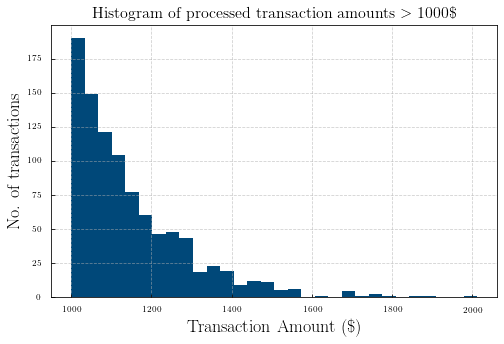

In [39]:
plt.figure(figsize=(8,5))
plt.hist(prossAmount[prossAmount>1000], color=cap1_blue, bins=30)
plt.grid(ls='--',alpha=0.6)
plt.title("Histogram of processed transaction amounts $> 1000\$ $", fontsize=16)
plt.xlabel(r'Transaction Amount $(\$)$',fontsize=18);plt.ylabel('No. of transactions', fontsize=18)
plt.show()

- **Structure in the data**

The distribution presents (approximately) what is known as a power law distribution, where transactions with large transaction amounts (e.g. $>10$) are much less frequent than transactions with small transaction amounts (e.g. $< 10 \$$).

Such distributions (sometimes known as the 80/20 law, long-tail distributions, pareto distribution etc) are prevelant in the distribution of social phenomena (e.g. distribution of city sizes, occurance of words in texts etc) where less extreme values (e.g. small towns, common words) occur in a disproportionally larger fraction. 

In the present case, the distribution we observe above can be easily explained by our common experience: we use our credit card many times over the course of a day to make small-amount purchases (e.g. buy a coffee, a quick meal etc), less frequently for intermediate-amount purchases (e.g. grocery store visits) and even less frequntly for large-amount purchases (e.g. plance tickets for international destinations etc). 


# Question 3: Data Wrangling - Duplicate Transactions <a class="anchor" id="third-question"></a>

In this part we will investigate duplicate transactions that are present in the dataset. Specifically we are interested in **reversed transactions** (when a purchase is followed by a reversal) and **multi-swipe** (accidentally charging a card multiple times).  

I spent a lot of time visually investigating the dataset, trying to get a sense of when reversed and multi-swipe transactions occur (and how they are encoded in the dataset). Here are some of my findings:


- First of all, there exist duplicates that do not seem to correspond to any of the above categories. For example one of the first duplicate transactions are two purchases on Play Store ($7.47\$$ each), that do not correspond to a reversed transaction (both have a `PURCHASE` label in the `transactionType` column), neither multi-swipe (happened with a difference of over a year).

- Some times between the PURCHASE and the REVRSAL other transactions have happened. Not all reversed transactions correspond to two subsequent rows in the dataset. 

- Although all the REVERSALS that I have inspected seem to have a corresponding PURCHASE (same transaction amount, same merchant name, same account number), I am not sure that all REVERSALS correspond to reversed purchases as defined here. For example, some may correspond to a smaller amount, due to errorneous initial amount in purchase, etc. In other words, we cannot be absolutely sure that selecting the transactions with a transaction type of `REVERSAL` will give us only reversed purchases.

- For multi-swipes: from my investigation, these are duplicate transactions that follow each other (subsequent rows) and within a short period of time (e.g. < 60 seconds).

So, here I will follow the follow **strategy** to define and **find** reversed and multi-swipe transactions:

- For **reversed transaction**: Find duplicates (two `transactionAmount` entries being the same), where the first one of them has a `transactionType` of PURCHASE and the second REVERSAL, by the same `accountNumber`, same credit card (as indicated by `cardLast4Digits`) and same `merchantName`. For simplicity, check duplicates that conform to those criteria and are separated by max 100 rows. (That's to simplify and make faster the computation). 

- Compare the results of the above method with those we get assuming that all transactions with a `REVERSAL` correspond to reversed purchases. 

- For **multi-swipe** transactions: Find duplicates (same `transactionAmount`entries being the), that both of them have a `transactionType` of PURCHASE and the time difference between them is small, let's say $<60$ seconds (although we can check how the results depend on the exact number).

### Reversed Transactions

Let's find the reversed transactions (total number and total amount) according to the above definition.

In [43]:
trans_type = trans_df['transactionType'] # Transaction type, we will need it
merch_name = trans_df['merchantName'] # Merchant name, we will need it

rev_amount = [] #Initialize a list that keeps the transaction amounts
rev_Fraud = [] # Initialize a list that keeps the Fraud/no Fraud labels

for i in range(1,100):
    # Difference between transaction amount
    diff_am_i = trans_df['transactionAmount'].diff(periods=i)
    # Difference in credit card numbers
    diff_card_i = trans_df['cardLast4Digits'].diff(periods=i)
    
    # Are the merchant names the same?
    merch_same = merch_name.eq(merch_name.shift(periods=i))
    
    
    # Define criteria for reversed
    crit_reversed = (diff_card_i==0)&(diff_am_i==0)&(trans_type=='REVERSAL')&(merch_same==True)
    reversed_trans = trans_df['transactionAmount'][crit_reversed]
    reversed_isFraud = trans_df['isFraud'][crit_reversed]
    
    # Append the lists
    rev_amount += list(reversed_trans.values)
    rev_Fraud += list(reversed_isFraud.values)  

In [44]:
print('Number of reversed transactions:',len(rev_amount))
print('Total transaction amount (in million dollars):',sum(rev_amount)/1e6)

Number of reversed transactions: 15604
Total transaction amount (in million dollars): 2.258749409999998


**Results**: We have about 15600 reversed transactions, amounting a total of $\sim 2.25$ million $\$$.

If we consider now all the reversals (not just the reversed transactions as we defined them above), then we have:

In [49]:
reversals = trans_df[trans_df['transactionType']=='REVERSAL']
trans__amount_reversals = trans_df[trans_df['transactionType']=='REVERSAL']['transactionAmount']

In [50]:
print(len(reversals))
print(sum(trans__amount_reversals)/1e6)

20303
2.8217924999999755


Thus if we were assuming that all transactions with some reversal correspond to reversed transactions, we now have $> 20000$ such transactions, with a total transaction amount of
$\sim2.82$  million $\$$.

### Multi-Swipe

Let's find now the multi-swipe transactions, according to the strategy mentioned above. I will also make the simplifying assumption that all of them are only happen two times in a row. 


**Update** Initially, I said that we would sent the time difference to be $<60$ seconds. However I relaized that results keep changing when increasing the time difference up to $<200$; after that threshold the number of multi-swipe transactions stops increasing.

In [53]:
swipe_amount = [] #Initialize a list that keeps the transaction amounts
swipe_Fraud = [] # Initialize a list that keeps the Fraud/no Fraud labels

for i in range(1,5):
    # Get differences between transaction amounts, only subsequent rows
    diff_amount = trans_df['transactionAmount'].diff(periods=i)
    # Get differences between credit card numbers, only subsequent rows
    diff_card = trans_df['cardLast4Digits'].diff(periods=i)
    # Are the merchant names the same?
    merch_same = merch_name.eq(merch_name.shift(periods=i))
    # Get differences between transaction date/time, only subsequent rows
    difftime = trans_df['transactionDateTime'].diff(periods=i)
    # Convert to seconds
    diff_seconds = difftime.dt.total_seconds().values


    # get the transactions that pass the multi-swipe criteria as stated earlier
    criteria = (diff_card==0)&(diff_amount==0)&(trans_type!='REVERSAL')&(merch_same==True)&(diff_seconds<200)
    mult_sw_trans = trans_df['transactionAmount'][criteria]
    mult_sw_Fraud = trans_df['isFraud'][criteria]
    
    # Append the lists
    swipe_amount += list(mult_sw_trans.values)
    swipe_Fraud += list(mult_sw_Fraud.values)  

Convert lists to arrays

In [54]:
rev_amount = np.asarray(rev_amount)
rev_Fraud = np.asarray(rev_Fraud)
swipe_amount = np.asarray(swipe_amount)
swipe_Fraud = np.asarray(swipe_Fraud)

In [55]:
print('Number of multi-swipe transactions:',len(swipe_amount))
print('Total transaction amount (in million dollars):',sum(swipe_amount)/1e6)

Number of multi-swipe transactions: 8142
Total transaction amount (in million dollars): 1.174953989999993


**Results:**

We have less multi-swipe transactions (8142) compared to reversed transactions, and a lower total transaction amount ($\sim 1.17$ million $\$$).

### Is there anything interesting about any of these two types fo transactions?

I suspect that these two types of transactioms may have something to tell us about the number of fraudulent transactions.

For example, a reversed transaction is more probable to have been reversed because it is a (suspected) fraud. Here I will investigate this hypothesis.

Let's start by plotting (normalized) histograms of the two type of transactions, and separate those belonging to the fraudulent and normal classes.

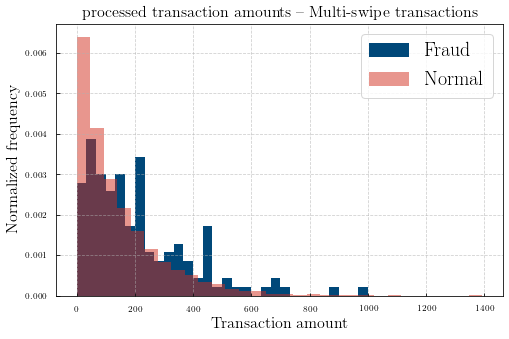

In [62]:
plt.figure(figsize=(8,5))

plt.hist(swipe_amount[swipe_Fraud==True],color=cap1_blue, bins=30,density=True,label='Fraud')
plt.hist(swipe_amount[swipe_Fraud==False],color=cap1_red, bins=30,density=True,alpha=0.5,label='Normal')
plt.grid(ls='--',alpha=0.6)
plt.title("processed transaction amounts -- Multi-swipe transactions", fontsize=16)

plt.xlabel('Transaction amount',fontsize=16)
plt.ylabel('Normalized frequency', fontsize=16)

plt.legend(frameon=True, loc='upper right', fontsize=20)
plt.show()

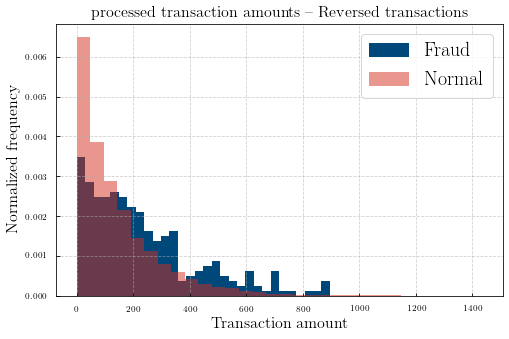

In [66]:
plt.figure(figsize=(8,5))

plt.hist(rev_amount[rev_Fraud==True],color=cap1_blue, bins=30,density=True,label='Fraud')
plt.hist(rev_amount[rev_Fraud==False],color=cap1_red, bins=30,density=True,alpha=0.5,label='Normal')

plt.grid(ls='--',alpha=0.6)
plt.title("processed transaction amounts -- Reversed transactions", fontsize=16)

plt.xlabel('Transaction amount',fontsize=16)
plt.ylabel('Normalized frequency', fontsize=16)
plt.legend(frameon=True, loc='upper right', fontsize=20)
plt.show()

The above plots show that in both cases we have more  fraudulent transactions  when considering higher transaction amounts; however this is generally true, not only for reversed or multi-swipe transactions, but for any type of transaction.

From the above plots it is not clear if there is anything particularly special about any of these transaction types.

### Relative number of fraudulent transactions at high transaction amounts

I will start with an **assumption**:

I assume (something that I honestly figured out by tinkering and inspecting data at high transaction amounts), that the proportion of fraudulent transactions compared to the total number of tranasctions will be higher for reversed transactions if we select transactions above an amount threshold.


For that reason I plot that proportion (fraudulent/total number of transactions) for different amount thresholds (select transactions above the threshold) and for: reversed, multi-swipe and all transaction (the whole dataset, including the reversed and multi-swipe).


In [67]:
tot_amount = trans_df['transactionAmount'].values
tot_Fraud =  trans_df['isFraud'].values

In [68]:
n_thresh = 100
thresh = np.linspace(10,600,n_thresh)
props_rev = np.zeros(n_thresh)
props_swipe = np.zeros(n_thresh)
props_tot = np.zeros(n_thresh)


for i in range(n_thresh):
    thres = thresh[i]
    props_rev[i] = len(rev_amount[(rev_Fraud==True)&(rev_amount>thres)])/len(rev_amount[(rev_amount>thres)])
    props_swipe[i] = len(swipe_amount[(swipe_Fraud==True)&(swipe_amount>thres)])/len(swipe_amount[(swipe_amount>thres)])
    props_tot[i] =  len(tot_amount[(tot_Fraud==True)&(tot_amount>thres)])/len(tot_amount[(tot_amount>thres)])

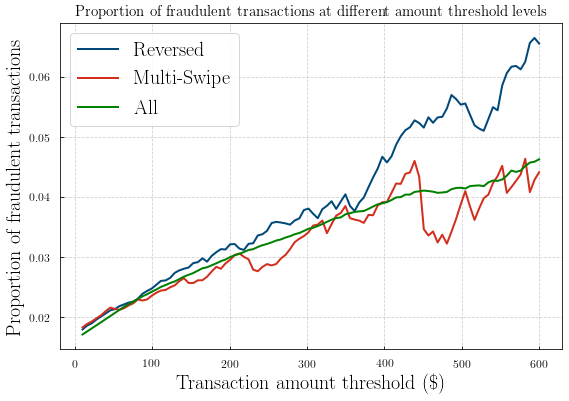

In [70]:
plt.figure(figsize=(9,6))


plt.plot(thresh,props_rev,c=cap1_blue,linewidth=2,label='Reversed')
plt.plot(thresh,props_swipe,c=cap1_red,linewidth=2, label='Multi-Swipe')
plt.plot(thresh,props_tot,c='green',linewidth=2, label='All')
plt.grid(ls='--',alpha=0.6)
plt.title('Proportion of fraudulent transactions at different amount threshold levels', fontsize=15)

plt.xticks(fontsize=12);plt.yticks(fontsize=12)
plt.xlabel('Transaction amount threshold ($\$$)', fontsize=20)
plt.ylabel('Proportion of fraudulent transactions', fontsize=20)
plt.legend(frameon=True, loc='upper left', fontsize=20)
plt.show()

**Results:** What we see in the above plot confirms my hypothesis: for large transaction amounts (e.g. $> 500 \$$), reversed transactions have a proportionally larger number of fraudulent transactions (note that however this is still quite low, about $6\%$ of the total number of reversed transactions).

# Question 4: Model 

Fraudulent credit card transactions is a serious problem in banking. In this part we will develop a predictive model for fraudulent transactions. Namely, we will use the data we have to train a **classifier** able to distinguish between a fraudulent and non-fraudulent (normal) transactions. 

## Target classes

Before start thinking about how to create this predictive model, let us inspect the number of examples in the target classes.  Below we calcuate the number and create a bar plot of the fraudulent and clean transactions.

In [119]:
# Get the target value classes (Fraud/Not Fraud)
# Convert the Boolean array (True/False) into integers (0/1) that
# A classifier can uderstand
y_target = trans_df['isFraud'].values.astype(int)

# Let's print and then plot the number of Fraudulent and non-Fraudulent transactions
n_Fraud = len(y_target[y_target==1])
n_nonFraud = len(y_target[y_target==0])

print('No. of fraudulent transactions:', n_Fraud)
print('No. of non-fraudulent transactions:', n_nonFraud)

No. of fraudulent transactions: 12417
No. of non-fraudulent transactions: 773946


Let's make a plot, to see that better

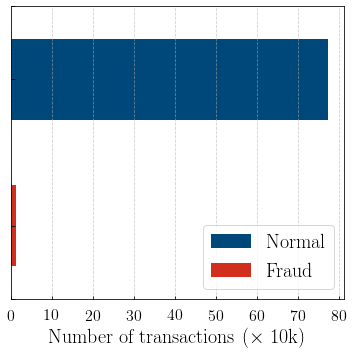

In [120]:
fig = plt.figure(figsize=(5.,5.))
plt.barh(4, n_nonFraud/10000, height=1.1, color=cap1_blue, label='Normal')
plt.barh(2, n_Fraud/10000, height=1.1, color=cap1_red, label='Fraud')
plt.grid(ls='--', axis='x', alpha=0.6)

plt.xticks(fontsize=16)
plt.yticks([1,2,4,5],(),fontsize=10)
plt.legend(frameon=True, loc='lower right', fontsize=20)
plt.xlabel(r'Number of transactions ($\times$ 10k)', fontsize=20)
plt.tight_layout()
plt.show()

We see that the target classes are **heavily imbalanced**, in other words we have many more non-fraudulent transactions ($\sim 774$k) than fraudulent ones ($\sim 12$k). The fraudulent transactions represent less than $1.6\%$ of the total number of transactions, something expected if the dataset represents real world data.

So, when building our predictive model we should appropriately take this class imbalance into account.


## Simplifying assumptions for a baseline model

Here, I will make a few assumptions for our first model.

- Assumption one: We will not use any **time information**. For example, one can imagine that the number of previous transactions, and even more importantly the number of previous fraudulent transactions by a specific credit number can be a strong predictor for future fraudulent behavior. However this requires a careful treatment of the way we split the dataset into training-validation-test sets, in order not to have leaking information between them, and blending forecasting with binary prediction models. We will drop it for now.

- Some acount numbers/credit cards or merchants may have a higher number of fraudulent transactions. But this require some splitting of data based on time, that we will avoid in our baseline feature selection.

- Furthermore, I assume that building a model based on past behavior of customer may not be very useful if we want to apply it to transactions from new customers. 

Having made this assumptions, let us start the dataset preprocessing.

## Dataset Preprocessing

Let's discuss and perform some data preprocessing steps here.

### Columns to drop

Based on the assumptions above, I will drop the following columns:

- `accountNumber`,`customerId`,`transactionDateTime`
- `merchantName`,`currentExpDate`, `accountOpenDate`
- `dateOfLastAddressChange`, `cardCVV`, `enteredCVV`,`cardLast4Digits`

Let's also drop the `isFraud` label column, since we have already kept the labels above. 

We drop the `cardCVV` and `enteredCVV` columns, we expect however that the fact these two are the same or not may provide significant information about an attempted fraudulent transaction.

Thus, before droping them, I will create a boolean array that is true if the two are the same and false otherwise.

Furthermore, we have two columns, `acqCountry` code, and `merchantCountryCode`. We create a new substitute them with a new feature that just shows if the two countries match, and then drop the `acqCountry`.


**Note:** Although it consumes memory, I find it to be a good practice to store to create a new dataframe every time I make a significant preprocessing change. That way it prevents accidental errors when, for example, running the same cell twice etc. I'll give them letter names, like df_a, df_b, etc

In [121]:
# Find if the CVVs match
matching_CVV = ~(trans_df.enteredCVV - trans_df.cardCVV).astype(bool)
# Convert to a dataframe
matching_CVV_df = pd.DataFrame({'matchCVV':matching_CVV})

# ==================================================================
# Boolean array - do the two countries match?
matching_countries = trans_df.acqCountry == trans_df.merchantCountryCode
# Convert to a dataframe
matching_countries_df = pd.DataFrame({'matchCountries':matching_countries})

In [122]:
# Make a list of the columns I am going to drop 
cols_to_drop = ['accountNumber','customerId','transactionDateTime',
               'currentExpDate', 'accountOpenDate','dateOfLastAddressChange','merchantName',
               'cardCVV', 'enteredCVV','cardLast4Digits','acqCountry','isFraud']

# Drop columns from the dataframe 
a_df = trans_df.drop(cols_to_drop, axis=1)

# Concatenate the dataframes
b_df = pd.concat([a_df,matching_CVV_df,matching_countries_df], axis=1)

### Impute missing values

We have seen that some columns/features have missing values. Although these are not many, and we could simply drop the rows that have missing values, because of the relatively low number of fraudulent transactions in the dataset, we don't want to drop any of them. For that reason, we impute the missing values with the most frequent value in the column where they occur. The choice of the "most frequent" was taken because the missing elements are in columns such the `posConditionCode`.

In [123]:
imp = SimpleImputer(missing_values=np.nan,strategy="most_frequent")
c_df = pd.DataFrame(imp.fit_transform(b_df), columns=b_df.columns)

### Log rescaling transformation

Some columns (like transaction amounts, credit limits) have very skewed distributions as we have seen. In such cases, it is better to perform a log rescaling (get the logarithm of the values) that maps the features to a smaller range.

In [124]:
d_df = c_df.copy()
# Credit Limit
d_df.creditLimit = c_df.creditLimit.astype(float).apply(np.log10)
# Available Money
d_df.availableMoney = c_df.availableMoney + 1010. #Add to make it always positive
d_df.availableMoney = d_df.availableMoney.astype(float).apply(np.log10)
# Current Balance
d_df.currentBalance = c_df.currentBalance+1.
d_df.currentBalance = d_df.currentBalance.astype(float).apply(np.log10)
# Transaction Amount
d_df.transactionAmount = c_df.transactionAmount+1.
d_df.transactionAmount = d_df.transactionAmount.astype(float).apply(np.log10)

### One-Hot encoding etc

Finally, some features (like the entry mode of the POS, the merchant category etc) come with some numrical or word descriptions that either cannot be directly fed to a machine learning model or, if the values are numerical, do not have have an ordinal relationship. In such cases we have to introduce a new  column for each one of the different values the feature can take. These columns are binary containing zeros and ones, ones representing the positions where the initial feature has the value represented by the new column (one-hot encoding). 

In [125]:
# Convert the boolean features to numeric (0/1)
d_df.cardPresent = c_df.cardPresent.astype(int)
d_df.expirationDateKeyInMatch = c_df.expirationDateKeyInMatch.astype(int)
d_df.matchCVV = c_df.matchCVV.astype(int)
d_df.matchCountries = c_df.matchCountries.astype(int)

# One hot-encoding

# Columns I'm going to perform one-hot encoding
cols_one_hot = ['merchantCountryCode','posEntryMode','posConditionCode',
                'merchantCategoryCode','transactionType']
# Perform OH encoding
e_df = pd.get_dummies(d_df, columns=cols_one_hot)

### Train-Validation-Test split and Rescaling

Here I write a function that splits the total dataset into training, validation, and test sets.
Furthermore it performs a min-max rescaling, where each feature gets a value between [0-1].

Note that the scaler is trained on the training set only in order to prevent **information leakage**.

In [126]:
# Get values of the from the dataframe
mat_values = e_df.values

# Train-validation-test split
# Write a function, in case we want to repeat it 
def dataset_split_scale(X,y):
    """
    Function that splits a matrix and a vector into
    training - validation - test sets.
    We also rescale the train, validation, test sets
    """
    scaler = MinMaxScaler()
    
    
    # First split into training set and a set for validation-test
    X_tr, X_valtest, y_tr, y_valtest = train_test_split(X,y,
                                                   stratify=y, #stratify to keep the proportions
                                                   test_size=0.2,random_state=42)
    # Now split the "valtest" set into validation and test sets
    X_val, X_test, y_val, y_test = train_test_split(X_valtest,y_valtest,
                                                   stratify=y_valtest, 
                                                   test_size=0.5,random_state=42)
    
    # Rescale
    scaler.fit(X_tr)
    X_tr_s = scaler.transform(X_tr)
    X_val_s = scaler.transform(X_val)
    X_test_s = scaler.transform(X_test)
    
    
    return X_tr_s, X_val_s, X_test_s, y_tr, y_val, y_test

# ===================================
# Get matrices - These are all rescaled
X_train, X_val, X_test, y_train, y_val, y_test = dataset_split_scale(mat_values,y_target)

## Model building: Predicting fraudulent transactions with Logistic Regression and Random Forrests 

Now that we have constructed, split and rescaled the feature matrices, it is time to build a predictive model.

### Dealing with class imbalance

As we have seen the dataset is heavily imbalanced. Training a classifier on that dataset is guaranteed to give very skewed results, since a classifier can achieve almost $100\%$ accuracy by just assigning every example to the majority class (normal transaction).

Thus we train the classification models on artificially balanced **training sets**. To achieve that, we fist (slightly) oversample the minority (fraud) class, and then undersample the majority class to achieve a balanced training dataset.

Specifically, I use the Synthetic Minority Oversampling Technique (SMOTE) provided by the `imbalance-learn` package to first increase the number of fraudulent examples to 10 percent of the total number of examples in the dataset. Then I use random undersampling to decrease the number of normal examples and create a balanced datase.

I want to emphasize that the balancing/resampling procedure should - and is - performed on the **training set only**. The **test** set **should remain imbalanced**, since it represents the real world situation where most transactions are normal and not fraudulent.

All evaluation metrics (precision, recall, confusion matrices) are calculated using that metric.


### Precision or Recall?

In imbalanced problems like this one, the accuracy is not a good metric.
Instead we will focus on the **recall** and the **precision** of the results (or their weigthed average, the F1 score).

- **Recall** shows the *completeness* of the classification; how many of the total fraudulent transactions the classifier was able to find.

The recall is defined as:

\begin{equation}
\mbox{Recall} = \frac{\mbox{TP}}{\mbox{TP+FN}}
\end{equation}
(FN is the number of False Negatives) and it characterizes the ability of the classifier to find all the positive samples (frauds in our case).



- **Precision** shows the *purity* of the positively classified examples; how many of those classified as fraudulent are indeed fraudulent?

Specifically, the precision score is defined as:

\begin{equation}
\mbox{Precision} =  \frac{\mbox{TP}}{\mbox{TP+FP}}
\end{equation}
(TP, FP being the true positive and false positives, respectiveley) and measures the ability of the classifier not to label a negative sample (normal) as positive (fraud).

For **practical applications** of fraud detection **recall is more important than the precision**: It is better to have false positives (normal transactions flagged as fraudulent) than false negatives (fraudulent transactions passing as normal). With suspicious transactions one can investigate more (by having a human to check the account behavior or by calling/texting the card holder).

Of course, we want the precision to be relatively high, too... Otherwise we would always be able to flag every transaction as fraudulent and have a perfect recall score.


In [127]:
# Define the SMOTE and RandomUnderSampling resamplers
smt = SMOTE(sampling_strategy=0.1,random_state=42) #minority class increase to 10% of total
rus = rus = RandomUnderSampler(sampling_strategy=1.0,random_state=42) #minority=majority numbers

# Build resampling pipeline
pipeline_res = Pipeline([('smt', smt), ('rus',rus)])

# Resample training set
X_tr_res, y_tr_res = pipeline_res.fit_resample(X_train,y_train)

### Logistic Regression

Our first model will be a logistic regression model, which is simple, fast and quite intuitive for a two-class problem like the one we have here.

Briefly, the logistic regression estimates the probability of an instance with features $x_1, x_2,\dots)$ to belong to class $Y=1$ (Fraud) as:

\begin{equation}
p(Y=1|X) = \frac{1}{1+e^{-(\beta_0 + \beta_1 x_1 + \beta_2 x_2 +\dots)}},
\end{equation}

where $\beta_0, \beta_1, \dots$ coefficients to be learned.

In [128]:
cls_LR = LogisticRegression(max_iter=1000,C=1.0,random_state=42)
cls_LR.fit(X_tr_res,y_tr_res)

y_pred_LR = cls_LR.predict(X_test)

**Confusion matrix function**

Write a function that creates nice confusion matrices - we will need it in many subsequent steps.

In [129]:
# Define function that plots confusion matrices
def plot_confusion(y_true,y_predict,method='Logistic Regression'):
    """
    Function that calculates and plots 
    confusion matrices
    """
    
    # Get confusion matrix
    con_mat = confusion_matrix(y_true,y_predict)
    
    # Class names
    class_names = ['Normal','Fraud']
    # =======================================
    #Plot
    plt.figure(figsize=(6.,6.))
    # Plot title
    plt.title('Confusion Matrix -'+ method,fontsize=15)
    
    sns.heatmap(con_mat, square=True, annot=True,
                fmt='d',annot_kws={"size":15},
                cmap='Blues',cbar=False,
                xticklabels=class_names,
                yticklabels=class_names)
    
    plt.xticks(fontsize=16);plt.yticks(fontsize=16)
    plt.xlabel('Predicted Label',fontsize=15)
    plt.ylabel('True Label',fontsize=15)
    plt.show()

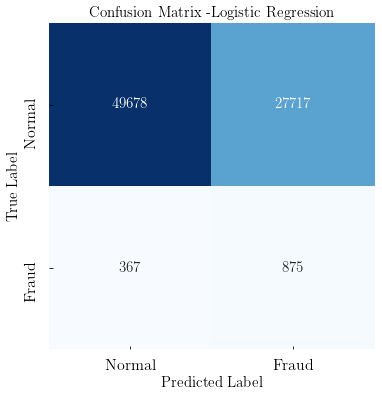

In [130]:
# Plot confusion matrix
plot_confusion(y_test,y_pred_LR)

In [131]:
print('Recall, Logistic Regression:',recall_score(y_test,y_pred_LR))
print('Precision, Logistic Regression:',precision_score(y_test,y_pred_LR))
print('F1 score, Logistic Regression:',f1_score(y_test,y_pred_LR))

Recall, Logistic Regression: 0.7045088566827697
Precision, Logistic Regression: 0.030602965864577503
F1 score, Logistic Regression: 0.05865790708587518


#### Tweaking the probability threshold

Lostic regression is a probabilistic classifier. The output is a the probability of an example to belong to the positie class (here "Fraud") that is converted to a class by assuming a probability threshold (default $p=0.5$).

However, we may want to change that probability threshold in order to optimize for better precision or recall.

In the following I explore how selecting a different probability threshold can give us better results.

In [132]:
def prediction_probas(clf, X_mat,y_true, probas):
    """
    Function that calculates and plots
    Precision and Recall at different probability levels
    """
    
    # Predict probability
    y_proba = clf.predict_proba(X_mat)[:,1]
    
    
    n = len(probas)
    precs = np.zeros(n)
    recs = np.zeros(n)
    
    for i in range(n):
        prob_thres = probas[i]
        
        # Binarize the classification
        # based on probability threshold
        y_bin = np.zeros(len(y_proba))
        y_bin[y_proba>prob_thres] = 1.0
        
        precs[i] = precision_score(y_true,y_bin)
        recs[i] = recall_score(y_true,y_bin)
        
    # Make plots
    # For precision
    plt.figure(figsize=(6.,4.))
    plt.plot(probas,precs,c=cap1_blue)
    plt.grid(ls='--', alpha=0.6)
    plt.yticks(fontsize=14)
    plt.xticks(fontsize=14)
    plt.ylabel('Precision', fontsize=15)
    plt.show()
    # For recall
    plt.figure(figsize=(6.,4.))
    plt.plot(probas,recs,c=cap1_red)
    plt.grid(ls='--', alpha=0.6)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('Probability threshold',fontsize=15)
    plt.ylabel('Recall', fontsize=15)
    plt.show()

**Plot precision and recall as a function of the probability threshold**

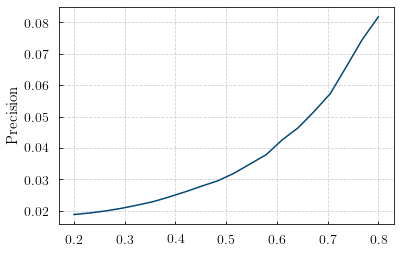

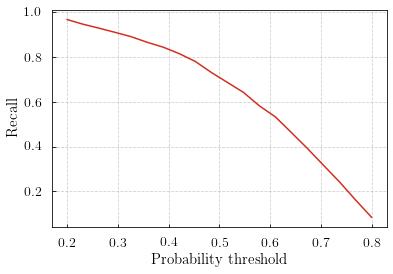

In [133]:
probs = np.linspace(0.2,0.8,20)
# Plot precision and recall as a function of threshold
prediction_probas(cls_LR, X_test,y_test, probs)

We see that setting the threshold to 0.4, for example, will significantly improve the recall but decrease the precision.
Let's plot the confusion matrix to see that.

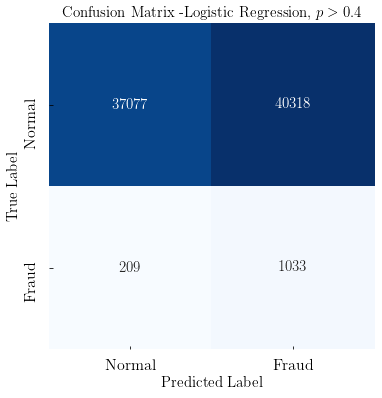

In [134]:
y_proba = cls_LR.predict_proba(X_test)[:,1]
y_bin = np.zeros(len(y_proba))
y_bin[y_proba>0.4] = 1.0
plot_confusion(y_test,y_bin,'Logistic Regression, $p>0.4$')

In [141]:
print('Recall, Logistic Regression, p>0.4:',recall_score(y_test,y_bin))
print('Precision, Random Forest, p>0.4:',precision_score(y_test,y_bin))
print('F1 score, Random Forest, p>0.4:',f1_score(y_test,y_bin))

Recall, Logistic Regression, p>0.4: 0.8317230273752013
Precision, Random Forest, p>0.4: 0.02498125801068898
F1 score, Random Forest, p>0.4: 0.048505622989693145


We see that we significantly improved the number of true positives (and the recall), with false negatives being less than $20\%$ of the number of all trully fraudulent transactions. At the same time though, the number of false positives has been significantly increased.

### Random Forest Classifier

Although the above results suggest that is probably hard to build a very good (=high precision and recall) classifier with the training dataset we have, let's try a classifier that is usually more powerful than the simple logistic regression.

A powerful classifier constructed by using many decision trees and then collecting the majority vote to perform the final classification is the Random Forest. 
Compared to the Logistic Regression it has more tunable hyperparameters.

Here we will perform Grid Search to optimize two of them, that I consider as very important, namely the number of trees and the minimum number 

In [135]:
# Grid of parameters to search for 
param_grid = {'n_estimators':[50,100,150],
             'min_samples_split':[2,10,15,20]}

# Random forest classfier initialize
RF_clf = RandomForestClassifier(random_state=0)

# Resample validation set
X_val_res, y_val_res = pipeline_res.fit_resample(X_val,y_val)

grid = GridSearchCV(RF_clf, param_grid,cv=5, scoring='recall')
grid.fit(X_val_res, y_val_res)
print(grid.best_params_)

{'min_samples_split': 2, 'n_estimators': 150}


In [136]:
RF_clf = RandomForestClassifier(n_estimators=150,min_samples_split=2,random_state=0)
RF_clf.fit(X_tr_res, y_tr_res)
y_pred_RF = RF_clf.predict(X_test)

Plot the confusion matrix now!

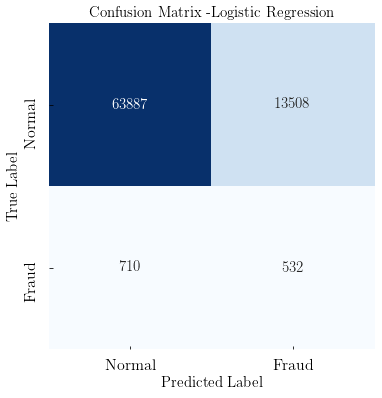

In [137]:
# Plot confusion matrix
plot_confusion(y_test,y_pred_RF)

In [138]:
print('Recall, Random Forest:',recall_score(y_test,y_pred_RF))
print('Precision, Random Forest:',precision_score(y_test,y_pred_RF))
print('F1 score, Random Forest:',f1_score(y_test,y_pred_RF))

Recall, Random Forest: 0.428341384863124
Precision, Random Forest: 0.037891737891737894
F1 score, Random Forest: 0.06962439471273393


We see that this (slightly) increased the precision, but at the expence of severely degrading the recall score.

### Summary: Baseline model(s) results

In this section I trained two classification models (Logistic regression and Random Forest) with the purpose of being able to predict if a given transaction is fraudulent or not.

In the case of the the Logistic regression, I considered separately the case when the standard $p=0.5$ output probability threshold (for an instance to be classified as Fraud) changed to $p=0.4$. The matrix below summarized the results (precision and recall):

| Model       || Precision   |      Recall   |  
| :---:       ||    :----:   |         :---: |     
| Log. Regression      || 0.031     | 0.704   |             
| Log. Regression (p>0.4)  || 0.025        | 0.832      |
| Random Forest  || 0.038 |  0.428    |

Although we were able to achieve high recall scores (>0.8 in the second case) these were at the expence of a *very poor* precision score. 

Specifically, from those transactions classified as fraudulent, only $3\%$ are actually fraudulent.


### Beyond the baseline model: Feature engineering

The results are rather poor, especially on the precision score.

We can try to improve them by engineering some (hopefully) informative features.

I will add the following two features now:

- Transaction amount outlier score: `AmountOut`: transaction amount/average transaction amount up to that point

This tell us if a transaction is larger (or smaller) than the average transaction the customer has made up to that transaction. I believe that this can be informative, since if there if the amount of a transaction is significantly higher than what the customer usually makes, it can be an indication of fraud.


- Mean transaction cumulative amount.

Just the average amount a customer has spent up to the time of a given transaction.

In [142]:
# Cumulative number of transactions 
cum_counts = trans_df.groupby(['customerId']).cumcount()+1  
# Average transaction amount
cum_trans_amount = trans_df.groupby(['customerId']).cumsum().transactionAmount 
mean_trans_amount = cum_trans_amount/cum_counts
# In some cases it can be equal to zero, make it 1
mean_trans_amount[mean_trans_amount==0] = 1 

e_df['meanAmount'] = mean_trans_amount.apply(np.log10)
e_df['AmountOut']= trans_df.transactionAmount/mean_trans_amount

- Past fraud

I am not sure if we can have access to past fraudulent transactions from a card as a predictor, but if so, this can be a strong predictor of future fraud.

So in this feature I consider the number of past fraudulent transactions of a credit card holder.
To make things more realistic I consider a **lag**. Specifically, I assume that Capital One may be able to check if a transaction is fraudulent or not in a period of a day. So when deploying the model, we will not the fraud "labels" of all the transaction up to ~1 day from a fraudulent transaction.

To make the generation of simple, instead of the more careful treatment of time differences, I just count the number of frauds up to 10 transactions before the current one.

In [143]:
past_fraud_count = trans_df.groupby(['customerId']).cumsum().isFraud.shift(+10).fillna(0)
past_fraud_count
e_df['avg_fraud'] = past_fraud_count#/cum_counts

**Get new feature matrix, standardize and split (train-validation-test sets), and then resample (balance) the training set**


Index "n" denotes "new"

In [144]:
# Get new feature matrix values
mat_values_new = e_df.values
# Split and standardize into training-validation-test sets
X_train_n, X_val_n, X_test_n, y_train_n, y_val_n, y_test_n = dataset_split_scale(mat_values_new,y_target)

In [145]:
# Resample training set
X_tr_res_n, y_tr_res_n = pipeline_res.fit_resample(X_train_n,y_train_n)

**Fit a new logistic regression classifier**

In [146]:
# Define
cls_LR_n = LogisticRegression(max_iter=1000,C=1.0,random_state=42)
# Fit
cls_LR_n.fit(X_tr_res_n,y_tr_res_n)
# Predict on the test set
y_pred_LR_n = cls_LR_n.predict(X_test_n)

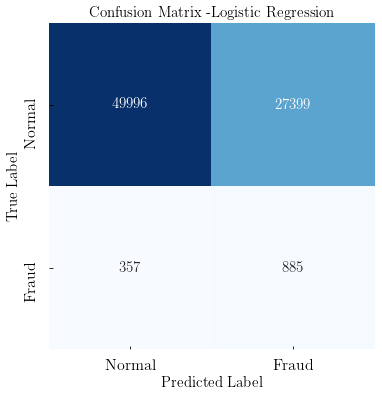

In [147]:
# Plot confusion matrix
plot_confusion(y_test_n,y_pred_LR_n)

In [148]:
print('Recall, Logistic Regression new:',recall_score(y_test_n,y_pred_LR_n))
print('Precision, Logistic Regression new:',precision_score(y_test_n,y_pred_LR_n))
print('F1 score, Logistic Regression new:',f1_score(y_test_n,y_pred_LR_n))

Recall, Logistic Regression new: 0.7125603864734299
Precision, Logistic Regression new: 0.031289775137887145
F1 score, Logistic Regression new: 0.05994716521032311


**Results by setting the probability threshold to $p>0.4$**

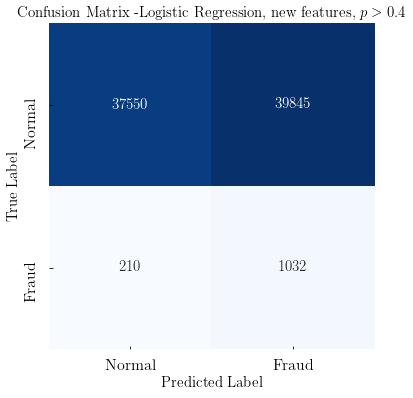

In [149]:
y_proba_n = cls_LR_n.predict_proba(X_test_n)[:,1]
y_bin_n = np.zeros(len(y_proba_n))
y_bin_n[y_proba_n>0.4] = 1.0
plot_confusion(y_test_n,y_bin_n,'Logistic Regression, new features, $p>0.4$')

In [150]:
print('Recall, Logistic Regression new:',recall_score(y_test_n,y_bin_n))
print('Precision, Logistic Regression new:',precision_score(y_test_n,y_bin_n))
print('F1 score, Logistic Regression new:',f1_score(y_test_n,y_bin_n))

Recall, Logistic Regression new: 0.8309178743961353
Precision, Logistic Regression new: 0.025246471120679112
F1 score, Logistic Regression new: 0.049004012440941144


**Results by setting the probability threshold to $p>0.6$**

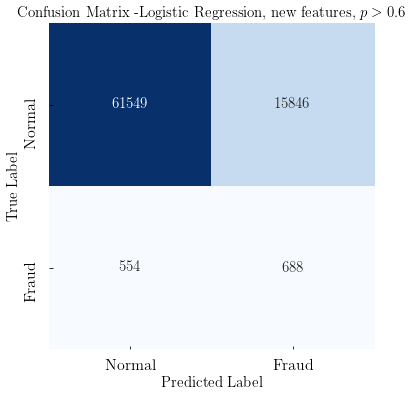

In [151]:
y_proba_n = cls_LR_n.predict_proba(X_test_n)[:,1]
y_bin_n = np.zeros(len(y_proba_n))
y_bin_n[y_proba_n>0.6] = 1.0
plot_confusion(y_test_n,y_bin_n,'Logistic Regression, new features, $p>0.6$')

In [152]:
print('Recall, Logistic Regression new:',recall_score(y_test_n,y_bin_n))
print('Precision, Logistic Regression new:',precision_score(y_test_n,y_bin_n))
print('F1 score, Logistic Regression new:',f1_score(y_test_n,y_bin_n))

Recall, Logistic Regression new: 0.5539452495974235
Precision, Logistic Regression new: 0.04161122535381638
F1 score, Logistic Regression new: 0.07740774077407742


**Summarize results**

| Model       || Precision   |      Recall   |  
| :---:       ||    :----:   |         :---: |    
| Log. Regression      || 0.031       | 0.712  |          
| Log. Regression (p>0.4)   || 0.025        | 0.831      | 
| Log. Regression (p>0.6)   || 0.041       | 0.554      | 


**Surprisingly, the results have been only marginally better than before, adding those new features I described above.**

### Finally, let's train a random forrest classifier, just to get the feature importances

In [153]:
RF_clf = RandomForestClassifier(n_estimators=150,min_samples_split=2,random_state=0)
RF_clf.fit(X_tr_res_n,y_tr_res_n)
y_pred_RF = RF_clf.predict(X_test_n)

Let's plot the 10 most important features

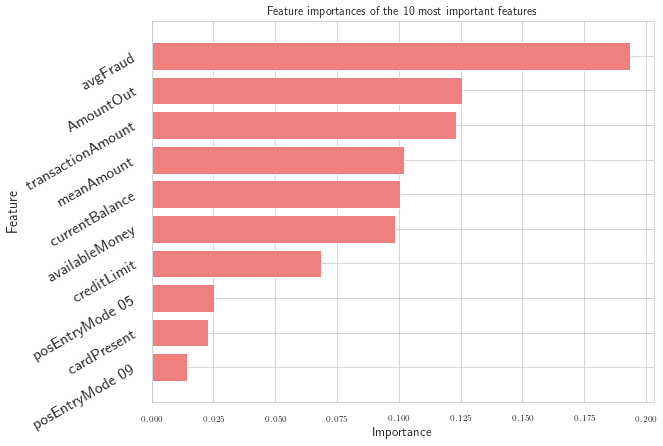

In [169]:
sns.set_style("whitegrid")
# Get labels of features
feat_labels = e_df.columns
feat_labels = np.asarray(feat_labels)
#print(feat_labels)


importances = RF_clf.feature_importances_
indices = np.argsort(importances)[::-1]
# Let's order now the feature labels based on their importances
ft_labels_ord = feat_labels[indices]

# Keep the 10 most important of them
import_sorted = importances[indices]
import_10 = import_sorted[:10]
ft_lab_10 = ft_labels_ord[:10]

# Define them manually because a broblem with latex
ft_lab_10 = ['avgFraud','AmountOut','transactionAmount','meanAmount','currentBalance', 
             'availableMoney','creditLimit','posEntryMode 05', 'cardPresent','posEntryMode 09']


plt.figure(figsize=(9,7))
plt.title("Feature importances of the 10 most important features ",fontsize=12)
plt.barh(range(10), import_10,
       color="lightcoral",  align="center")
plt.yticks(range(10), ft_lab_10,fontsize=16, rotation=30)
plt.ylim([10,-1])

plt.ylabel('Feature',fontsize=14)
plt.xlabel('Importance',fontsize=13)
plt.show()

As expected, the most informative features *are* those generated, like the average past fraud, and the ratio of a transaction amount over the average past transactions.

## Final conclusions and what I would do if I had more time 

In this part I built predictive model to determine whether a given transaction will be fraudulent or not.

I was able to achieve a recall score of $\sim 0.8$ but with very poor precision scores.

In other words, although the classifier is able to find and correctly classify as fraudulent the majority of fraudulent transactions, but at the expense of a very large number of false positives (normal transactions classified as fraudulent).

Despite that we would certainly want to build a better classifier, even these results can add value to Capital One when trying to track fradulent transactions.

For example, we can assume that this classifier can be the first step in a more detailed analysis, it can reduce the number of transactions that need to be checked by half, while being sure that we miss less than $20\%$ of the fraudulent transaction.



What I would do to improve results:

**Feature Engineering**

Having more time I would try to generate more informative features. Some of them could be:

- Number of transactions over a time window. 

- Amount of transactions over a past time window.

- Infrequent merchant numbers/ customer makes a transaction from a new merchant

- amount of transaction / average amount of transaction in category.

**Test different classifiers and hyperparamter tuning**

- I would test different classifiers (XGboost, SVMs, maybe a simple neural network) with more careful hyperparameter tuning.

- Check correlation between features and remove the most highly correlated.


**Anomaly detection algorithms**

I am not expert on this class of algorithms, but since the "fraud" class is a fraction of all transactions, it can be treated as an "anomaly"

